In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import dask.dataframe as dd
from dask.distributed import Client
import wrds
import os
from statsmodels.sandbox.regression import gmm
from statsmodels.api import OLS

In [2]:
# Import data

def request_wrds(path: str,
                 start_date: pd.Timestamp,
                 end_date: pd.Timestamp) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    with wrds.Connection() as db:
        df_s12 = db.raw_sql(f'''
            SELECT *
            FROM tfn.s12
            WHERE fdate >= '{start_date}' AND fdate <= '{end_date}'
        ''', date_cols=['fdate'])
        df_s12.to_csv(f'{path}s12.csv')

        df_s12type5 = db.raw_sql(f'''
                    SELECT *
                    FROM tfn.s12type5
                    WHERE fdate >= '{start_date}' AND fdate <= '{end_date}'
                ''', date_cols=['fdate'])
        df_s12type5.to_csv(f'{path}df_s12type5.csv')
    
        df_s34 = db.raw_sql(f'''
            SELECT *
            FROM tfn.s34
            WHERE fdate >= '{start_date}' AND fdate <= '{end_date}'
        ''', date_cols=['fdate'])
        df_s34.to_csv(f'{path}s34.csv')

        df_beta = db.raw_sql(f'''
            SELECT *
            FROM beta.ff3
            WHERE date >= '{start_date}' AND date <= '{end_date}'
        ''', date_cols=['date'])
        df_beta.to_csv(f'{path}security.csv')

        df_security = db.raw_sql(f'''
            SELECT *
            FROM crspm.crspm_stock
            WHERE date >= '{start_date}' AND date <= '{end_date}'
        ''', date_cols=['date'])
        df_security.to_csv(f'{path}security.csv')

        return df_s12, df_s34, df_security


def dask_read(path: str) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):
    try:
        df_s12 = dd.read_csv(f'{path}s12.csv', encoding='ISO-8859-1')
        log_import_s12(df_s12)

        df_s12type5 = dd.read_csv(f'{path}s12type5.csv', encoding='ISO-8859-1')
        log_import_s12type5(df_s12type5)

        df_s34 = dd.read_csv(f'{path}s34.csv', encoding='ISO-8859-1')
        log_import_s34(df_s34)

        df_beta = dd.read_csv(f'{path}beta.csv', encoding='ISO-8859-1')
        log_import_beta(df_beta)

        df_security = dd.read_csv(f'{path}security.csv', encoding='ISO-8859-1')
        log_import_security(df_security)

        return df_s12, df_s12type5, df_s34, df_beta, df_security
    
    except FileNotFoundError:
        return request_wrds(path, start_date, end_date)


def pandas_read(path: str) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):
    try:
        df_s12 = pd.read_csv(f'{path}s12.csv', encoding='ISO-8859-1', low_memory=False)
        log_import_s12(df_s12)

        df_s12type5 = pd.read_csv(f'{path}s12type5.csv', encoding='ISO-8859-1', low_memory=False)
        log_import_s12type5(df_s12type5)

        df_s34 = pd.read_csv(f'{path}s34.csv', encoding='ISO-8859-1', low_memory=False)
        log_import_s34(df_s34)

        df_beta = pd.read_csv(f'{path}beta.csv', encoding='ISO-8859-1', low_memory=False)
        log_import_beta(df_beta)

        df_security = pd.read_csv(f'{path}security.csv', encoding='ISO-8859-1', low_memory=False)
        log_import_security(df_security)

        return df_s12, df_s12type5, df_s34, df_beta, df_security
    
    except FileNotFoundError:
        return request_wrds(path, start_date, end_date)


def clean_imports(df_s12,
                  df_s12type5,
                  df_s34,
                  df_beta,
                  df_security,
                  start_date,
                  end_date
                  ) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):

    df_s12_clean = clean_s12(df_s12, start_date, end_date)
    log_clean_s12(df_s12_clean)

    df_s12type5_clean = clean_s12type5(df_s12type5, start_date, end_date)
    log_clean_s12type5(df_s12type5_clean)

    df_s34_clean = clean_s34(df_s34, start_date, end_date)
    log_clean_s34(df_s34_clean)

    df_beta_clean = clean_beta(df_beta, start_date, end_date)
    log_clean_beta(df_beta_clean)

    df_security_clean = clean_security(df_security, start_date, end_date)
    log_clean_security(df_security_clean)

    return df_s12_clean, df_s12type5_clean, df_s34_clean, df_beta_clean, df_security_clean


def clean_s12(df: pd.DataFrame, start_date: pd.Timestamp, end_date: pd.Timestamp) -> pd.DataFrame:
    columns = [
        'fundno',
        'rdate',
        'cusip',
        'shares'
    ]
    return (df[columns]
            .dropna(how='any', subset=['fundno', 'shares', 'cusip'])
            .rename(columns={
                'rdate': 'date',
                'fundno': 'inv_id',
                'cusip': 'asset_id'})
            .assign(date=lambda x: fix_date(x['date']))
            .loc[lambda x: (x['date'] >= start_date) & (x['date'] <= end_date)]
            .drop_duplicates(subset=['inv_id', 'date', 'asset_id'], keep='last'))


def clean_s12type5(df: pd.DataFrame, start_date: pd.Timestamp, end_date: pd.Timestamp) -> pd.DataFrame:
    return (df.rename(columns={'fdate': 'date', 'fundno': 'inv_id'})
            .assign(date=lambda x: fix_date(x['date']))
            .loc[lambda x: (x['date'] >= start_date) & (x['date'] <= end_date)]
            .dropna(how='any', subset=['inv_id', 'date']))


def clean_s34(df: pd.DataFrame, start_date: pd.Timestamp, end_date: pd.Timestamp) -> pd.DataFrame:
    columns = [
        'mgrno',
        'rdate',
        'typecode',
        'cusip',
        'shares'
    ]
    return (df[columns]
            .dropna(how='any', subset=['mgrno', 'rdate', 'cusip', 'shares'])
            .rename(columns={
                'rdate': 'date',
                'mgrno': 'inv_id',
                'cusip': 'asset_id'})
            .assign(date=lambda x: fix_date(x['date']))
            .loc[lambda x: (x['date'] >= start_date) & (x['date'] <= end_date)]
            .drop_duplicates(subset=['inv_id', 'date', 'asset_id'], keep='last'))


def clean_beta(df: pd.DataFrame, start_date: pd.Timestamp, end_date: pd.Timestamp) -> pd.DataFrame:
    columns=[
        'PERMNO',
        'DATE',
        'b_mkt',
        'b_smb',
        'b_hml'
    ]
    offset = 6
    return (df[columns]
            .dropna()
            .rename(columns={
                'DATE': 'date',
                'PERMNO':'permno'})
            .assign(date=lambda x: fix_date(x['date']) + offset)
            .loc[lambda x: (x['date'] >= start_date) & (x['date'] <= end_date)]
            .drop_duplicates(subset=['date', 'permno'], keep='last'))


def clean_security(df: pd.DataFrame, start_date: pd.Timestamp, end_date: pd.Timestamp) -> pd.DataFrame:
    columns = [
        'LPERMNO',
        'cusip',
        'datadate',
        'prccm',
        'trt1m',
        'cshoq'
    ]
    offset = 6
    return (df[columns]
            .rename(columns={
                'LPERMNO': 'permno',
                'cusip': 'asset_id',
                'prccm': 'prc',
                'cshoq': 'shrout',
                'datadate': 'date'})
            .assign(shrout=lambda x: x.groupby('asset_id')['shrout'].ffill() * 1000000,
                    asset_id=lambda x: x['asset_id'].apply(lambda s: s[:-1]),
                    date=lambda x: fix_date(x['date']) + offset)
            .dropna(how='any', subset=['asset_id', 'prc', 'shrout'])
            .loc[lambda x: (x['date'] >= start_date) & (x['date'] <= end_date)]
            .drop_duplicates(subset=['date', 'permno'], keep='last'))


# def fix_date(dates: pd.Series) -> pd.Series:
#     return pd.to_datetime(dates) + pd.offsets.MonthEnd(0)


def fix_date(dates: pd.Series) -> pd.Series:
    return pd.to_datetime(dates).dt.to_period(freq='M')

In [3]:
# Stocks Monthly

def merge_assets_factors(df_assets: pd.DataFrame, df_factors: pd.DataFrame) -> pd.DataFrame:
    df_merged = pd.merge(
        left=df_assets,
        right=df_factors,
        how='left',
        on=['date', 'permno'])

    df_merged_indexed = (df_merged
                         .assign(shrout=lambda x: x['shrout'].astype('int64'),
                                 date=lambda x: x['date'].dt.asfreq('Q'))
                         .drop_duplicates(subset=['date', 'asset_id'], keep='last')
                         .drop(columns=['permno']))

    log_asset_merge(df_merged_indexed)
    return df_merged_indexed


# Manager / Holdings

def match_fund_manager(df_fund: pd.DataFrame, df_manager: pd.DataFrame, df_key: pd.DataFrame) -> pd.DataFrame:
    df_fund_manager = (df_manager
                       .assign(shares=lambda x: x['shares'].astype('int64'),
                               date=lambda x: x['date'].dt.asfreq(freq='Q'))
                       .drop_duplicates(subset=['inv_id', 'date', 'asset_id'], keep='last'))
    
    log_holding_merge(df_fund_manager)
    return df_fund_manager


def construct_zero_holdings(df_fund_manager: pd.DataFrame, n_quarters: int) -> pd.DataFrame:
    
    def calc_inv_obs(df: pd.DataFrame) -> pd.DataFrame:
        date_diff = (df.groupby('inv_id')['date'].transform('max') - df['date']).apply(lambda x: x.n)
        min_diff = np.minimum(date_diff, n_quarters) + 1
        return min_diff
    
    def calc_asset_obs(df: pd.DataFrame) -> pd.DataFrame:
        date_diff = (df.sort_values('date')
                     .groupby(['inv_id', 'asset_id'])
                     ['date']
                     .diff(periods=1)
                     .fillna(pd.DateOffset(n=1))
                     .apply(lambda x: x.n))
        min_diff = np.minimum(date_diff, df['inv_obs'])
        return min_diff.apply(lambda x: list(range(x)))
    
    df_holding = (df_fund_manager
                  .assign(inv_obs=lambda x: calc_inv_obs(x),
                          asset_obs=lambda x: calc_asset_obs(x))
                  .explode('asset_obs')
                  .assign(asset_obs=lambda x: x['asset_obs'].astype('int8'),
                          mask=lambda x: x['asset_obs'] == 0,
                          shares=lambda x: x['shares'] * x['mask'],
                          date=lambda x: x['date'] + x['asset_obs'])
                  .drop(columns=['inv_obs', 'asset_obs', 'mask']))
        
    log_zero_holdings(df_holding)
    return df_holding

def merge_holding_factor(df_holding: pd.DataFrame, df_asset: pd.DataFrame) -> pd.DataFrame:
    df_merged = pd.merge(
        left=df_holding,
        right=df_asset,
        how='left',
        on=['date', 'asset_id'])

    df_holding_factor = (df_merged
                         .assign(shares=lambda x: np.minimum(x['shares'], x['shrout']),
                                 holding=lambda x: x['prc'] * x['shares'] / 1000000,
                                 me=lambda x: x['prc'] * x['shrout'] / 1000000,
                                 typecode=lambda x: x['typecode'].fillna(0).astype('int8'))
                         .dropna(subset='holding'))
    
    log_holding_factor_merge(df_holding_factor)
    return df_holding_factor


def drop_unsused_inv_asset(df_holding_factor: pd.DataFrame) -> pd.DataFrame:
    df_dropped = (df_holding_factor
                  .assign(Tinv_shares=lambda x: x.groupby(['inv_id', 'date'])['shares'].transform('sum'),
                          Tasset_shares=lambda x: x.groupby(['date', 'asset_id'])['shares'].transform('sum'),
                          mask=lambda x: (x['Tinv_shares'] == 0) | (x['Tasset_shares'] == 0))
                  .loc[lambda x: ~x['mask']]
                  .drop(columns=['Tinv_shares', 'Tasset_shares', 'mask']))
    
    log_drop_unused(df_dropped)
    return df_dropped


def create_household_sector(df_dropped: pd.DataFrame) -> pd.DataFrame:
    df_household = (df_dropped
                      .groupby(['date', 'asset_id'], as_index=False)
                      .agg({
                        'shares': 'sum',
                        'prc': 'last',
                        'shrout': 'last',
                        'b_mkt': 'last',
                        'b_smb': 'last',
                        'b_hml': 'last',
                        'holding': 'sum',
                        'me': 'last'})
                      .assign(shares=lambda x: np.maximum(x['shrout'] - x['shares'], 0),
                              holding=lambda x: np.maximum(x['me'] - x['holding'], 0),
                              inv_id=0,
                              typecode=0))
    
    log_household_sector(df_household)
    df_concat = pd.concat([df_dropped, df_household])
    return df_concat

In [4]:
# Data

def partition_outside_asset(df_household: pd.DataFrame) -> pd.DataFrame:
    df_outside = (df_household
                  .assign(out_mask=lambda x: x.isna().any(axis=1),
                          out_holding=lambda x: x['holding'] * x['out_mask']))
    
    log_outside_asset(df_outside)
    return df_outside


def calc_inv_aum(df_outside: pd.DataFrame) -> pd.DataFrame:
    df_grouped = df_outside.groupby(['inv_id', 'date'])
    
    df_inv_aum = (df_outside
                  .assign(aum=lambda x: df_grouped['holding'].transform('sum'),
                          out_aum=lambda x: df_grouped['out_holding'].transform('sum'),
                          out_weight=lambda x: x['out_aum'] / x['aum']))

    log_inv_aum(df_inv_aum)
    return df_inv_aum


def agg_small_inv(df_inv_aum: pd.DataFrame) -> pd.DataFrame:
    df_agg = (df_inv_aum
              .assign(small_mask=lambda x: (x['aum'] < 10) | (x['out_weight'] == 0) | (x['out_weight'] == 1),
                      inv_id=lambda x: ~x['small_mask'] * x['inv_id'],
                      hh_mask=lambda x: x['inv_id'] == 0))

    df_grouped = df_agg.groupby(['inv_id', 'date', 'asset_id'])
    
    df_agg = (df_agg
              .assign(Tshares=lambda x: df_grouped['shares'].transform('sum'),
                      Tholding=lambda x: df_grouped['holding'].transform('sum'),
                      shares=lambda x: np.where(x['hh_mask'], x['Tshares'], x['shares']),
                      holding=lambda x: np.where(x['hh_mask'], x['Tholding'], x['holding']))
              .drop(columns=['Tshares', 'Tholding']))
    
    df_grouped = df_agg.groupby(['inv_id', 'date'])
    
    df_agg = (df_agg
              .assign(Taum=lambda x: df_grouped['holding'].transform('sum'),
                      Tout_aum=lambda x: df_grouped['out_holding'].transform('sum'),
                      aum=lambda x: np.where(x['hh_mask'], x['Taum'], x['aum']),
                      out_aum=lambda x: np.where(x['hh_mask'], x['Tout_aum'], x['out_aum']),
                      x_holding=lambda x: df_grouped['holding'].transform('count'),
                      n_holding=lambda x: x['x_holding'] - df_grouped['out_mask'].transform('sum'),
                      equal_alloc=lambda x: ~x['hh_mask'] * x['aum'] / (1 + x['x_holding']),
                      drop_mask=lambda x: x['small_mask'] | x['out_mask'])
              .loc[lambda x: ~x['drop_mask']]
              .drop(columns=['Taum', 'Tout_aum', 'out_mask', 'out_holding', 'out_weight', 'small_mask', 'drop_mask']))
    
    log_agg_small_inv(df_agg)
    return df_agg
    

def bin_inv(df_inv_aum: pd.DataFrame, min_n_holding: int) -> (pd.DataFrame, pd.DataFrame):
    mask = df_inv_aum['n_holding'] >= min_n_holding
    
    df_binned = (df_inv_aum
                 .assign(bin=0))
    
    log_bins(df_binned)
    return df_binned


def calc_instrument(df_binned: pd.DataFrame) -> pd.DataFrame:    
    df_instrument = (df_binned
                     .assign(total_alloc=lambda x: x.groupby(['date', 'asset_id'])['equal_alloc'].transform('sum'),
                             iv_me=lambda x: x['total_alloc'] - x['equal_alloc'])
                     .drop(columns=['total_alloc', 'equal_alloc']))
    
    log_instrument(df_instrument)
    return df_instrument


def dask_calc_instrument(df_binned: pd.DataFrame) -> pd.DataFrame:
    df_binned = dd.from_pandas(df_binned.set_index('date'), npartitions=32)
    
    df_instrument = (df_binned
                     .assign(total_alloc=lambda x: x.groupby(['date', 'asset_id'])['equal_alloc'].transform('sum', meta=pd.Series(dtype='float64')),
                             iv_me=lambda x: x['total_alloc'] - x['equal_alloc'])
                     .drop(columns=['total_alloc', 'equal_alloc'])
                     .compute()
                     .reset_index())
    
    log_instrument(df_instrument)
    return df_instrument

In [5]:
# Estimation

def calc_holding_weights(df_instrument: pd.DataFrame, min_n_holding: int) -> pd.DataFrame:
    mask = (df_instrument['n_holding'] >= min_n_holding) & (df_instrument['iv_me'] > 0)

    df_weights = (df_instrument.loc[mask]
                 .assign(ln_me=lambda x: np.log(x['me']),
                         ln_iv_me=lambda x: np.log(x['iv_me']),
                         rweight=lambda x: x['holding'] / x['out_aum'],
                         ln_rweight=lambda x: np.log(x['rweight']).replace(-np.inf, np.nan),
                         mean_ln_rweight=lambda x: x.groupby(['inv_id', 'date'])['ln_rweight'].transform('mean'),
                         const=1,
                         pct_uni_held=lambda x: np.log(x['n_holding']) - np.log(x['x_holding']))
                .drop(columns=['me', 'iv_me']))
    
    log_holding_weights(df_weights)
    return df_weights


def unpack_result(result: gmm.GMMResults) -> dict:
    return result.params


def bound_float(arr: np.array) -> float:
    ln_bound = 709.7827
    return np.minimum(np.maximum(arr, -ln_bound), ln_bound)


def estimate_model_L(df_weights: pd.DataFrame, characteristics: list, params: list) -> pd.DataFrame:
    
    def momcond_L(params, exog):
        upper_bound = 0.999
        exog = exog.T
        
        beta_ln_me = params[0]
        beta_characteristics = params[1:]
        
        ln_me = exog[0]
        mean_ln_rweight = exog[1]
        arr_characteristics = exog[2:]
        
        ln_me_term = (upper_bound - np.exp(-1 * beta_ln_me)) * ln_me
        characteristics_term = np.dot(beta_characteristics, arr_characteristics)
        pred_weight = ln_me_term + characteristics_term + mean_ln_rweight
        
        return pred_weight
    
    def fit_inv_date_L(df_inv_date: pd.DataFrame) -> gmm.GMMResults:
        df_inv_date = df_inv_date.dropna(subset='ln_rweight')
        
        exog = np.asarray(df_inv_date[['ln_me', 'mean_ln_rweight'] + characteristics])
        instrument = np.asarray(df_inv_date[['ln_iv_me', 'mean_ln_rweight'] + characteristics])
        n = exog.shape[0]
        endog = np.asarray(df_inv_date['ln_rweight'] - df_inv_date['pct_uni_held'])
        start_params = np.zeros(len(params))
        w0inv = np.dot(instrument.T, instrument) / n
        
        try:
            model = gmm.NonlinearIVGMM(
                endog=endog,
                exog=exog,
                instrument=instrument, 
                func=momcond_L)
            result = model.fit(
                start_params=start_params,
                maxiter=0,
                inv_weights=w0inv)
            
            # log_results(result, params)
            return result
        
        except np.linalg.LinAlgError:
            print('Linear Algebra Error')
            return None
    
    
    df_model = (df_weights
                .set_index(['inv_id', 'date'])
                .assign(gmm_result=lambda x: x.groupby(['inv_id', 'date']).apply(fit_inv_date_L),
                        lst_params=lambda x: x['gmm_result'].apply(unpack_result))
                .reset_index())
    df_model[params] = pd.DataFrame(df_model['lst_params'].tolist(), index=df_model.index)
    df_model = df_model.drop(columns='lst_params')
    
    log_params(df_model)
    return df_model



def estimate_model_NL(df_weights: pd.DataFrame, characteristics: list, params: list) -> pd.DataFrame:
    
    def momcond_NL(params, exog):
        upper_bound = 0.9999
        exog = exog.T
        
        beta_ln_me = bound_float(params[0])
        beta_characteristics = params[1:]
        
        ln_me = exog[0]
        rweight = exog[1]
        mean_ln_rweight = exog[2]
        arr_characteristics = exog[3:]
        
        ln_me_term = (upper_bound - np.exp(-1 * beta_ln_me)) * ln_me
        characteristics_term = np.dot(beta_characteristics, arr_characteristics)
        pred_ln_rweight = bound_float(ln_me_term + characteristics_term + mean_ln_rweight)
        pred_rweight = np.exp(-1 * pred_ln_rweight)
        
        return rweight * pred_rweight
    
    def fit_inv_date_NL(df_inv_date: pd.DataFrame) -> gmm.GMMResults:
        exog = np.asarray(df_inv_date[['ln_me', 'rweight', 'mean_ln_rweight'] + characteristics])
        instrument = np.asarray(df_inv_date[['ln_iv_me', 'rweight', 'mean_ln_rweight'] + characteristics])
        n = exog.shape[0]
        endog = np.ones(n)
        
        try:
            model = gmm.NonlinearIVGMM(
                endog=endog,
                exog=exog,
                instrument=instrument, 
                func=momcond_NL)
            w0inv = np.dot(instrument.T, instrument) / n
            start_params = np.zeros(len(params))
            result = model.fit(
                start_params=start_params,
                maxiter=100,
                inv_weights=w0inv)
            
            # log_results(result, params)
            return result
        
        except np.linalg.LinAlgError:
            print('Linear Algebra Error')
            return None
    
    df_model = (df_weights
                .set_index(['inv_id', 'date'])
                .assign(gmm_result=lambda x: x.groupby(['inv_id', 'date']).apply(fit_inv_date_NL)))
    # df_model = (df_weights
    #             .assign(gmm_result=lambda x: x.groupby(['inv_id', 'date']).apply(fit_inv_date_2).reset_index(drop=True),
    #                     lst_params=lambda x: x['gmm_result'].apply(unpack_result)))
    # df_model[params] = pd.DataFrame(df_model['lst_params'].tolist(), index=df_model.index)
    # df_model = df_model.drop(columns='lst_params')
    
    log_params(df_model)
    return df_model


def calc_latent_demand_L(df_model: pd.DataFrame, characteristics: list, params: list) -> pd.DataFrame:
    upper_bound = 0.9999
    
    df_results = (df_model
                  .assign(beta_ln_me=lambda x: upper_bound - np.exp(-1 * x['beta_ln_me']),
                          beta_const=lambda x: x['beta_const'] + x['mean_ln_rweight'],
                          pred_ln_rweight=lambda x: np.einsum('ij,ij->i', x[['ln_me'] + characteristics], x[params]),
                          latent_demand=lambda x: x['ln_rweight'] - x['pred_ln_rweight']))
    
    log_latent_demand(df_results)
    return df_results

In [6]:
# Liquidity



In [51]:
# Figures

def clean_figures(df_results: pd.DataFrame) -> pd.DataFrame:
    return (df_results
            .assign(date=lambda x: x['date'].dt.to_timestamp(),
                    typecode=lambda x: x['typecode'].apply(get_readable_typecode)))


def typecode_share_counts(df_figure: pd.DataFrame, figure_path: str):
    df_type_share = (df_figure
                     .groupby(['typecode', 'date'])
                     .agg({'aum': 'sum', 'n_holding': 'count'})
                     .assign(share=lambda x: x['aum'] / x['aum'].groupby('date').transform('sum')))
    
    g = sns.relplot(data=df_type_share, x='date', y='n_holding', hue='typecode', kind='line')
    g.set_axis_labels('Date', 'Number of Investors')
    g.despine()
    plt.savefig(os.path.join(figure_path, f'typecode_count.png'))
    
    g = sns.relplot(data=df_type_share, x='date', y='share', hue='typecode', kind='line')
    g.set_axis_labels('Date', 'Share of AUM')
    g.despine()
    plt.savefig(os.path.join(figure_path, f'typecode_share.png'))
    
    return df_inv_aum


def check_moment_condition(df_results: pd.DataFrame, mom: int):
    df_mom = (df_results
              .groupby(['inv_id', 'date'])
              .agg({'latent_demand': 'mean'}))
    
    epsilon = 0.001
    mask = (df_mom['latent_demand'] > mom - epsilon) & (df_mom['latent_demand'] < mom + epsilon)
    valid_rate = len(df_mom[mask]) / len(df_mom)
    print(f'Percentage of valid portfolios:  {100*valid_rate:.4f}%')
    
    g = sns.displot(
        data=df_mom,
        x='latent_demand'
    )
    g.set_axis_labels('Log Latent Demand', 'Frequency')
    g.despine()
    plt.savefig(os.path.join(figure_path, f'moment_condition.png'))
    
    return df_results


def critical_value_test(df_figures: pd.DataFrame, characteristics: list, figure_path: str):
    
    def iv_reg(df_inv_date: pd.DataFrame):
        y = df_inv_date['ln_me']
        X = df_inv_date[['ln_iv_me'] + characteristics]
        model = OLS(y, X)
        result = model.fit()
        t_stat = result.tvalues.iloc[0]
        
        return t_stat
    
    df_iv = (df_figures
             .groupby(['inv_id', 'date'])
             .apply(iv_reg)
             .to_frame('t_stat')
             .groupby('date')
             .min()
             .reset_index())
    
    g = sns.relplot(
        data=df_iv,
        x='date',
        y='t_stat',
        kind='line')
    g.refline(
        y=4.05,
        linestyle='--')
    g.set_axis_labels('Date', 'First stage t-statistic')
    g.despine()
    plt.savefig(os.path.join(figure_path, f'instrument_validity.png'))
    
    return df_figures


def test_index_fund(df_figures: pd.DataFrame, characteristics: list, params: list, indexfund_id: int, figure_path: str):
    mask = df_figures['inv_id'] == indexfund_id
    df_index_fund = (df_figures
                     .assign(ln_rweight=lambda x: x['ln_me'] + x['mean_ln_rweight'],
                             pct_uni_held=1)
                     .loc[mask])
    
    df_index_fund_model = estimate_model_L(df_index_fund, characteristics, params)
    df_index_fund_result = calc_latent_demand_L(df_index_fund_model, characteristics, params)
    cols = params + ['latent_demand']
    for param in cols:
        g = sns.relplot(data=df_index_fund_result,
                        x='date',
                        y=param,
                        kind='line')
        g.set_axis_labels('Date', f'{get_readable_param(param)}')
        g.despine()
        plt.ylim(-1, 1)
        plt.savefig(os.path.join(figure_path, f'index_fund_{param}.png'))
        
    return df_figures
    

def graph_type_params(df_results: pd.DataFrame, params: list, figure_path: str):
    df_types = df_results.copy()
    df_types[params] = df_types[params].apply(lambda x: x * df_results['aum'])
    df_types = (df_types
                .groupby(['typecode', 'date'])
                [params]
                .sum()
                .apply(lambda x: x / df_results.groupby(['typecode', 'date'])['aum'].sum()))
    
    for param in params:
        g = sns.relplot(data=df_types, 
                        x='date',
                        y=param,
                        hue='typecode',
                        kind='line')
        g.set_axis_labels('Date', f'{get_readable_param(param)}')
        g.legend.set_title('Institution Type')
        g.despine()
        plt.savefig(os.path.join(figure_path, f'{param}.png'))
        
    return df_results


def graph_std_latent_demand(df_figures: pd.DataFrame, figure_path: str):
    df_ld = (df_figures
         .groupby(['inv_id', 'date'])
         .agg({
            'latent_demand': 'std',
            'aum': 'last',
            'typecode': 'last'})
         .assign(latent_demand=lambda x: x['latent_demand'] * x['aum'])
         .groupby(['typecode', 'date'])
         .agg({
            'latent_demand': 'mean',
            'aum': 'sum'})
         .assign(latent_demand=lambda x: x['latent_demand'] / x['aum']))
    
    g = sns.relplot(data=df_ld, 
                    x='date',
                    y='latent_demand',
                    hue='typecode',
                    kind='line')
    g.set_axis_labels('Date', 'Standard Deviation of Latent Demand')
    g.legend.set_title('Institution Type')
    g.despine()
    plt.savefig(os.path.join(figure_path, f'std_latent_demand.png'))
    
    return df_results


def create_tables(df_figures: pd.DataFrame):
    return df_figures


def get_param_cols(cols: list) -> list:
    return ['beta_' + col for col in cols]


def get_readable_param(name: str) -> str:
    return name.replace('_', ' ').title()


def get_readable_typecode(typecode: int):
    return dict_typecode[typecode]

In [8]:
# Log

def log_import_s12(df_s12: pd.DataFrame):
    dateindex_s12 = df_s12['rdate']
    print('Imported s12')
    print('Number of holdings:  ', len(df_s12))
    print('Earliest date:  ', min(dateindex_s12))
    print('Latest date:  ', max(dateindex_s12))


def log_import_s12type5(df_s12type5: pd.DataFrame):
    dateindex_s12type5 = df_s12type5['fdate']
    print()
    print('Imported s12type5')
    print('Number of holdings:  ', len(df_s12type5))
    print('Earliest date:  ', min(dateindex_s12type5))
    print('Latest date:  ', max(dateindex_s12type5))


def log_import_s34(df_s34: pd.DataFrame):
    dateindex_s34 = df_s34['rdate']
    print()
    print('Imported s34')
    print('Number of holdings:  ', len(df_s34))
    print('Earliest date:  ', min(dateindex_s34))
    print('Latest date:  ', max(dateindex_s34))


def log_import_beta(df_beta: pd.DataFrame):
    dateindex_ffm = df_beta['DATE']
    print()
    print('Imported betas')
    print('Number of dates:  ', len(df_beta))
    print('Earliest date:  ', min(dateindex_ffm))
    print('Latest date:  ', max(dateindex_ffm))


def log_import_security(df_security: pd.DataFrame):
    dateindex_security = df_security['datadate']
    print()
    print('Imported security')
    print('Number of holdings:  ', len(df_security))
    print('Earliest date:  ', min(dateindex_security))
    print('Latest date:  ', max(dateindex_security))


def log_clean_s12(df_s12_clean: pd.DataFrame):
    dateindex_s12 = df_s12_clean['date']
    print()
    print('Cleaned s12')
    print('Number of holdings:  ', len(df_s12_clean))
    print('Earliest date:  ', min(dateindex_s12))
    print('Latest date:  ', max(dateindex_s12))


def log_clean_s12type5(df_s12type5_clean: pd.DataFrame):
    dateindex_s12type5 = df_s12type5_clean['date']
    print()
    print('Cleaned s12type5')
    print('Number of firm/dates:  ', len(df_s12type5_clean))
    print('Earliest date:  ', min(dateindex_s12type5))
    print('Latest date:  ', max(dateindex_s12type5))


def log_clean_s34(df_s34_clean: pd.DataFrame):
    dateindex_s34 = df_s34_clean['date']
    print()
    print('Cleaned s34')
    print('Number of holdings:  ', len(df_s34_clean))
    print('Earliest date:  ', min(dateindex_s34))
    print('Latest date:  ', max(dateindex_s34))


def log_clean_beta(df_beta_clean: pd.DataFrame):
    dateindex_beta = df_beta_clean['date']
    print()
    print('Cleaned beta')
    print('Number of dates:  ', len(df_beta_clean))
    print('Earliest date:  ', min(dateindex_beta))
    print('Latest date:  ', max(dateindex_beta))


def log_clean_security(df_security_clean: pd.DataFrame):
    dateindex_security = df_security_clean['date']
    print()
    print('Cleaned security')
    print('Number of asset/dates:  ', len(df_security_clean))
    print('Earliest date:  ', min(dateindex_security))
    print('Latest date:  ', max(dateindex_security))


def log_holding_merge(df_merged: pd.DataFrame):
    print()
    print('Merged s12 and s34')
    print('Number of holdings:  ', len(df_merged))
    print()


def log_drop_unused(df_dropped: pd.DataFrame):
    print()
    print('Dropped unused investors/assets')
    print('Number of holdings:  ', len(df_dropped))
    print()


def log_asset_merge(df_merged: pd.DataFrame):
    print()
    print('Merged assets and factors')
    print('Number of assets/dates:  ', len(df_merged))
    print()


def log_holding_factor_merge(df_merged: pd.DataFrame):
    print()
    print('Merged holdings and factors')
    print('Number of investor/date/asset:  ', len(df_merged))
    print()


def log_household_sector(df_household: pd.DataFrame):
    print()
    print('Created household sector')
    print('Number of holdings:  ', len(df_household))


def log_outside_asset(df_outside: pd.DataFrame):
    print()
    print('Created outside asset')
    print('Number of outside holdings:  ', df_outside['out_mask'].sum())


def log_zero_holdings(df_holding: pd.DataFrame):
    print()
    print('Constructed zero holdings')
    print('Number of non-zero holdings:  ', sum(df_holding['shares'] > 0))
    print('Number of zero holdings:  ', sum(df_holding['shares'] == 0))


def log_inv_aum(df_inv_aum: pd.DataFrame):
    print()
    print('Calculated investor AUM')
    print('Number of investors:  ', len(df_inv_aum['inv_id'].unique()))


def log_agg_small_inv(df_agg: pd.DataFrame):
    print()
    print('Aggregated small investors')
    print('Number of investors:  ', len(df_agg['inv_id'].unique()))


def log_bins(df_binned: pd.DataFrame):
    print()
    print('Binned investors')
    print('Number of investors:  ', len(df_binned['inv_id'].unique()))
    print('Number of bins:  ', len(df_binned['bin'].unique()))


def log_inv_universe(df_inv_uni: pd.DataFrame):
    idx = df_inv_uni['inv_id'].unique()
    print()
    print('Created investment universe')
    print('Number of investors:  ', len(idx))
    print('Average investment universe size:  ', len(df_inv_uni['uni_size'].mean()))
    

def log_instrument(df_instrument: pd.DataFrame):
    print()
    print('Created market equity instrument')
    print('Number of valid instruments:  ', sum(df_instrument['iv_me'] > 0))
    print('Number of invalid instruments:  ', sum(df_instrument['iv_me'] == 0))
    

def log_holding_weights(df_model: pd.DataFrame):
    print()
    print('Calculated holding weights')
    print('Number of non-zero holdings:  ', sum(df_model['holding'] > 0))
    print('Number of zero holdings:  ', sum(df_model['holding'] == 0))


def log_results(result, params):
    print()
    print(result.summary(yname='Latent demand', xname=params))
    print()
    

def log_params(df_params: pd.DataFrame):
    print()
    print('Estimated parameters')
    print('Number of converged estimations:  ', sum(df_params['gmm_result'].notna()))
    print('Number of unconverged estimations:  ', sum(df_params['gmm_result'].isna()))
    
    
def log_latent_demand(df_results: pd.DataFrame):
    print()
    print('Calculated latent demand')
    print('Number of investors:  ', len(df_results['inv_id'].unique()))

In [35]:
# Global parameters

sns.set_theme(style='ticks', palette=sns.color_palette('hls', 6), context='paper')

input_path = 'data/'
output_path = 'output/'
figure_path = 'figures/'

os.makedirs(output_path, exist_ok=True)
os.makedirs(figure_path, exist_ok=True)

start_date = pd.Period('2012-01')
end_date = pd.Period('2017-12')

characteristics = [
    'b_mkt',
    'b_smb',
    'b_hml'
] + ['const']
params = ['beta_ln_me'] + get_param_cols(characteristics)
dict_typecode = {
     0: 'Households',
     1: 'Banks',
     2: 'Insurance companies',
     3: 'Investment advisors',
     4: 'Mutual funds',
     5: 'Pension funds',
}

min_n_holding = 1000
n_quarters = 11
indexfund_id = 90457

In [10]:
def main():
    
    client = Client()
    
    dfs = dask_read(input_path)
    df_s12_clean, df_s12type5_clean, df_s34_clean, df_beta_clean, df_security_clean = clean_imports(
        *dfs,
        start_date,
        end_date
    )
    
    df_fund_manager = match_fund_manager(df_s12_clean, df_s34_clean, df_s12type5_clean)
    
    df_holding = (df_fund_manager
                  .pipe(construct_zero_holdings, n_quarters))
    
    df_asset = merge_assets_factors(df_security_clean, df_beta_clean)
    df_holding_factor = merge_holding_factor(df_holding, df_asset)
    
    df_output = (df_holding_factor
                 .pipe(drop_unsused_inv_asset)
                 .pipe(create_household_sector)
                 .pipe(partition_outside_asset)
                 .pipe(calc_inv_aum)
                 .pipe(agg_small_inv)
                 .pipe(bin_inv, min_n_holding)
                 .pipe(calc_instrument)
                 .pipe(calc_holding_weights, min_n_holding)
                 .pipe(estimate_model_L, characteristics, params)
                 .pipe(calc_latent_demand_L, characteristics, params)
                 .pipe(clean_figures)
                 .pipe(typecode_share_counts, figure_path)
                 .pipe(check_moment_condition, 1)
                 .pipe(critical_value_test, characteristics, figure_path)
                 .pipe(test_index_fund, characteristics, params, figure_path)
                 .pipe(graph_type_params, params, figure_path)
                 .pipe(graph_std_latent_demand, figure_path))
    df_output.to_csv(os.path.join(output_path, 'df_output.csv'))
    

In [11]:
# Main

print('\n---------------Starting Imports---------------------------\n')
dfs = pandas_read(input_path)


---------------Starting Imports---------------------------

Imported s12
Number of holdings:   30987
Earliest date:   2014-06-30
Latest date:   2017-12-31

Imported s12type5
Number of holdings:   572518
Earliest date:   12/31/1994
Latest date:   9/30/2022

Imported s34
Number of holdings:   22707709
Earliest date:   2012-03-31
Latest date:   2017-12-31

Imported betas
Number of dates:   432458
Earliest date:   2012-01-31
Latest date:   2017-12-29

Imported security
Number of holdings:   402452
Earliest date:   2012-01-31
Latest date:   2017-12-31


In [12]:
print('\n---------------Starting Cleaning---------------------------\n')
df_s12_clean, df_s12type5_clean, df_s34_clean, df_beta_clean, df_security_clean = clean_imports(
    *dfs,
    start_date,
    end_date
)

# df_s12_clean.to_csv(os.path.join(output_path, 'df_s12_clean.csv'))
# df_s12type5_clean.to_csv(os.path.join(output_path, 'df_s12type5_clean.csv'))
# df_s34_clean.to_csv(os.path.join(output_path, 'df_s34_clean.csv'))
# df_beta_clean.to_csv(os.path.join(output_path, 'df_beta_clean.csv'))
# df_security_clean.to_csv(os.path.join(output_path, 'df_security_clean.csv'))


---------------Starting Cleaning---------------------------

Cleaned s12
Number of holdings:   27327
Earliest date:   2014-06
Latest date:   2017-12

Cleaned s12type5
Number of firm/dates:   49372
Earliest date:   2012-03
Latest date:   2017-12

Cleaned s34
Number of holdings:   22267070
Earliest date:   2012-03
Latest date:   2017-12

Cleaned beta
Number of dates:   394535
Earliest date:   2012-07
Latest date:   2017-12

Cleaned security
Number of asset/dates:   348924
Earliest date:   2012-07
Latest date:   2017-12


In [13]:
print('\n---------------Merging Assets/Factors---------------------------\n')
df_asset = merge_assets_factors(df_security_clean, df_beta_clean)
# df_asset.to_csv(os.path.join(output_path, 'df_asset.csv'))

print('\n---------------Merging s12/s34 Holdings---------------------------\n')
df_fund_manager = match_fund_manager(df_s12_clean, df_s34_clean, df_s12type5_clean)
# df_fund_manager.to_csv(os.path.join(output_path, 'df_fund_manager.csv'))


---------------Merging Assets/Factors---------------------------

Merged assets and factors
Number of assets/dates:   118413


---------------Merging s12/s34 Holdings---------------------------

Merged s12 and s34
Number of holdings:   22267070


In [14]:
print('\n---------------Constructing Zero Holdings---------------------------\n')
df_holding = construct_zero_holdings(df_fund_manager, n_quarters)
# df_holding.to_csv(os.path.join(output_path, 'df_holding.csv'))


---------------Constructing Zero Holdings---------------------------

Constructed zero holdings
Number of non-zero holdings:   22267070
Number of zero holdings:   2478516


In [15]:
print('\n---------------Merging Holdings/Factors---------------------------\n')
df_holding_factor = merge_holding_factor(df_holding, df_asset)
# df_holding_factor.to_csv(os.path.join(output_path, 'df_holding_factor.csv'))


---------------Merging Holdings/Factors---------------------------

Merged holdings and factors
Number of investor/date/asset:   18074588


In [16]:
print('\n---------------Dropping Mangers/Assets Without Holdings---------------------------\n')
df_dropped = drop_unsused_inv_asset(df_holding_factor)
# df_holding.to_csv(os.path.join(output_path, 'df_holding.csv'))

print('\n---------------Creating Household Sector---------------------------\n')
df_household = create_household_sector(df_dropped)
# df_household.to_csv(os.path.join(output_path, 'df_household.csv'))

print('\n---------------Partitioning Outside Asset---------------------------\n')
df_outside = partition_outside_asset(df_household)
# df_outside.to_csv(os.path.join(output_path, 'df_outside.csv'))


---------------Dropping Mangers/Assets Without Holdings---------------------------

Dropped unused investors/assets
Number of holdings:   18029864


---------------Creating Household Sector---------------------------

Created household sector
Number of holdings:   87361

---------------Partitioning Outside Asset---------------------------

Created outside asset
Number of outside holdings:   1096998


In [17]:
print('\n---------------Calculating Investor AUM---------------------------\n')
df_inv_aum = calc_inv_aum(df_outside)
# df_inv_aum.to_csv(os.path.join(output_path, 'df_inv_aum.csv'))


---------------Calculating Investor AUM---------------------------

Calculated investor AUM
Number of investors:   5972


In [18]:
print('\n---------------Aggregating Small Investors---------------------------\n')
df_agg = agg_small_inv(df_inv_aum)
# df_agg.to_csv(os.path.join(output_path, 'df_agg.csv'))


---------------Aggregating Small Investors---------------------------

Aggregated small investors
Number of investors:   5163


In [19]:
print('\n---------------Pooling Investors By Type/Size---------------------------\n')
df_binned = bin_inv(df_agg, min_n_holding)
# df_binned.to_csv(os.path.join(output_path, 'df_binned.csv'))


---------------Pooling Investors By Type/Size---------------------------

Binned investors
Number of investors:   5163
Number of bins:   1


In [20]:
print('\n---------------Calculating Instrument---------------------------\n')
df_instrument = calc_instrument(df_binned)
# df_instrument.to_csv(os.path.join(output_path, 'df_instrument.csv'))


---------------Calculating Instrument---------------------------

Created market equity instrument
Number of valid instruments:   16362962
Number of invalid instruments:   378


In [21]:
print('\n---------------Calculating Holding Weights---------------------------\n')
df_weights = calc_holding_weights(df_instrument, min_n_holding)
# df_weights.to_csv(os.path.join(output_path, 'df_weights.csv'))


---------------Calculating Holding Weights---------------------------


C:\Users\wyatt\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



Calculated holding weights
Number of non-zero holdings:   6027887
Number of zero holdings:   800114


In [22]:
print('\n---------------Estimating Demand System---------------------------\n')
df_model = estimate_model_L(df_weights, characteristics, params)
# df_model.to_csv(os.path.join(output_path, 'df_model.csv'))


---------------Estimating Demand System---------------------------
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0

In [23]:
print('\n---------------Calculating Latent Demand---------------------------\n')
df_results = calc_latent_demand_L(df_model, characteristics, params)
# df_results.to_csv(os.path.join(output_path, 'df_results.csv'))


---------------Calculating Latent Demand---------------------------

Calculated latent demand
Number of investors:   336



---------------Testing Moment Condition---------------------------
Percentage of valid portfolios:  0.0000%


C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


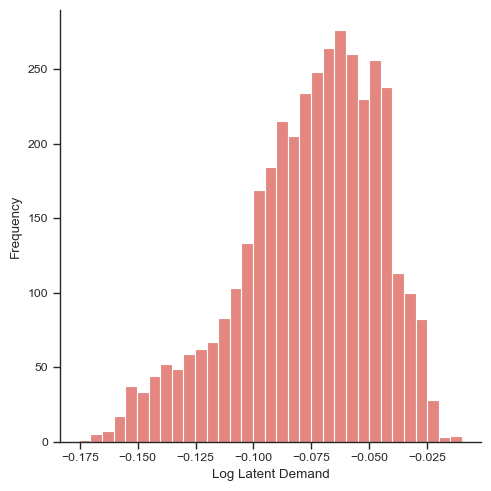

In [24]:
print('\n---------------Testing Moment Condition---------------------------\n')
df_figures = clean_figures(df_results)
_ = check_moment_condition(df_figures, 0)


---------------Investors by Typecode---------------------------


C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

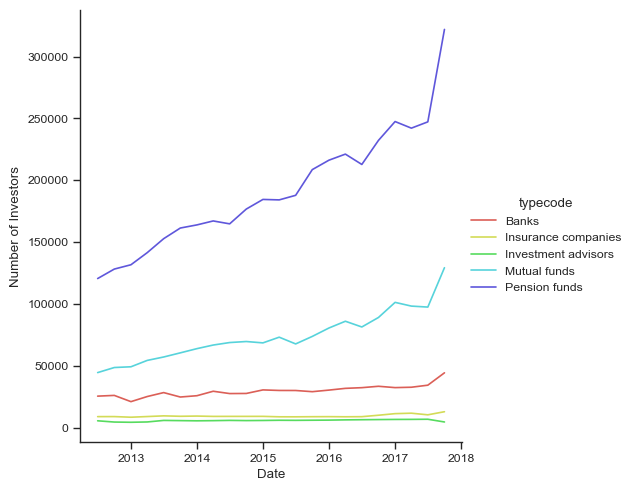

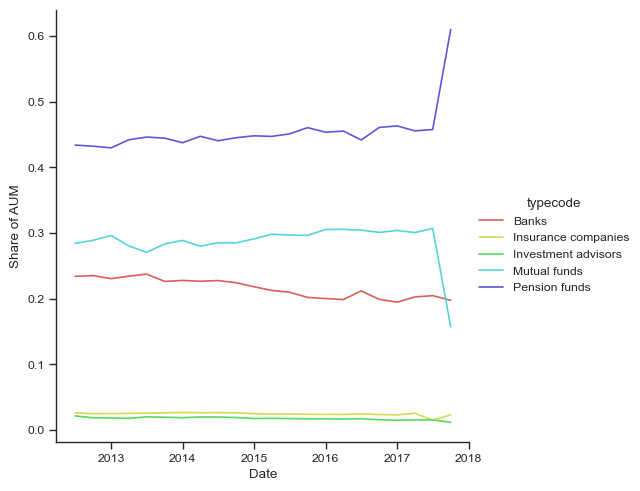

In [25]:
print('\n---------------Investors by Typecode---------------------------\n')
_ = typecode_share_counts(df_figures, figure_path)


---------------Testing Instrument Validity---------------------------


C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


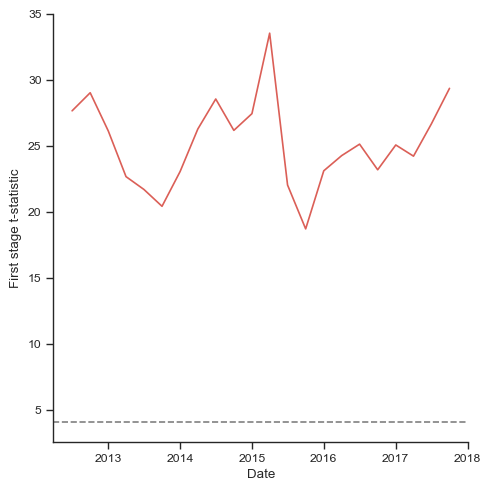

In [31]:
print('\n---------------Testing Instrument Validity---------------------------\n')
_ = critical_value_test(df_figures, characteristics, figure_path)


---------------Testing Hypothetical Index Fund---------------------------
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 47
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 48
         Function evaluations: 51
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 48
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 50
         Function evaluations: 53
         Gradient evaluations: 53
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 50
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function v

C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

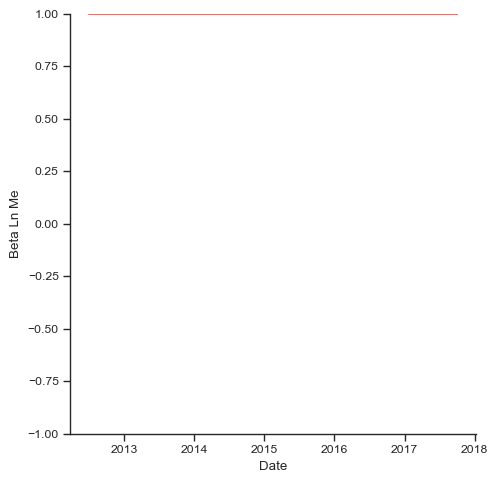

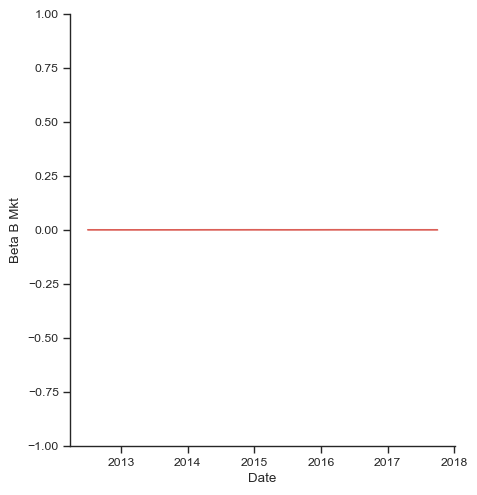

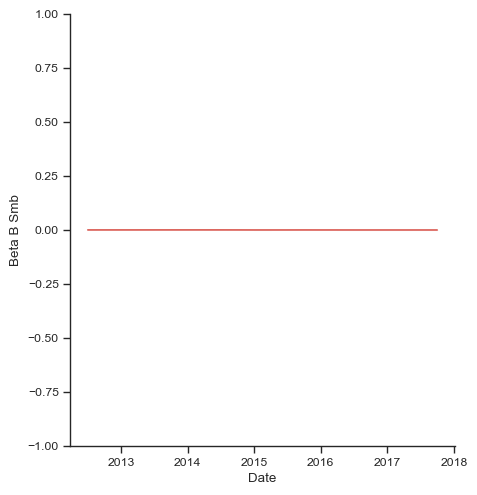

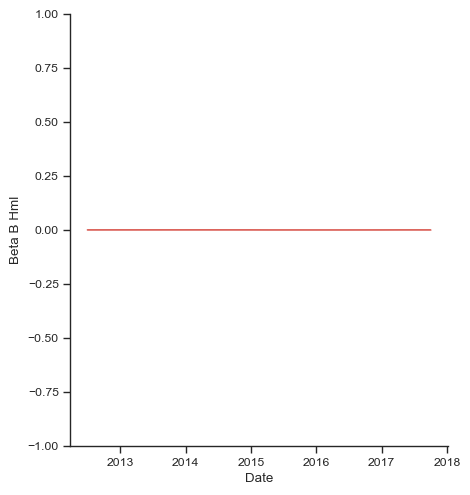

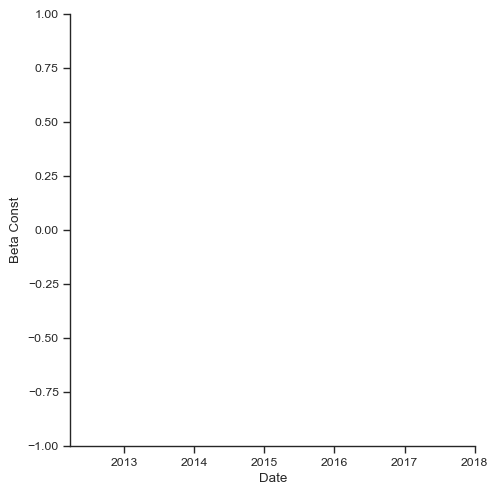

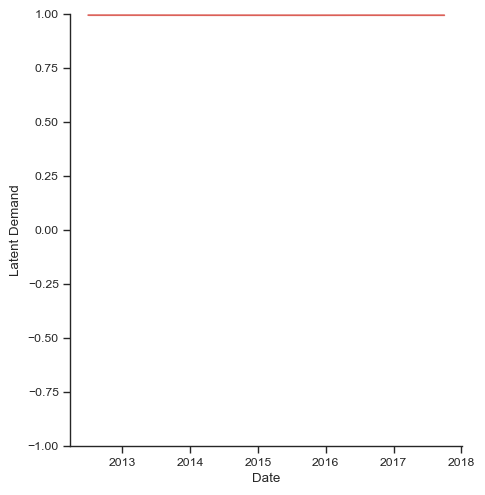

In [49]:
print('\n---------------Testing Hypothetical Index Fund---------------------------\n')
_ = test_index_fund(df_figures, characteristics, params, indexfund_id, figure_path)


---------------Parameters By Typecode---------------------------


C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

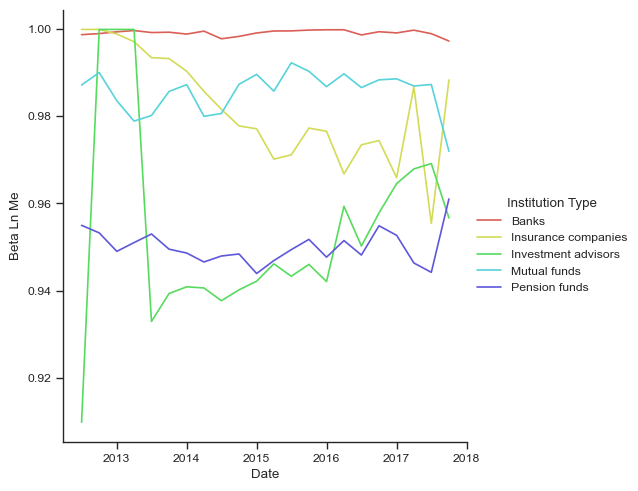

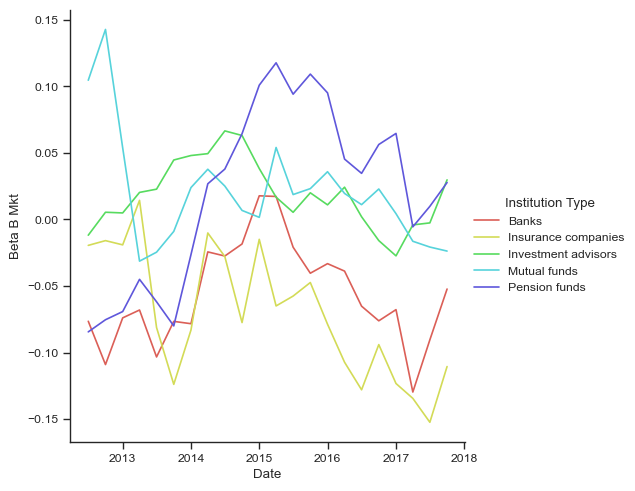

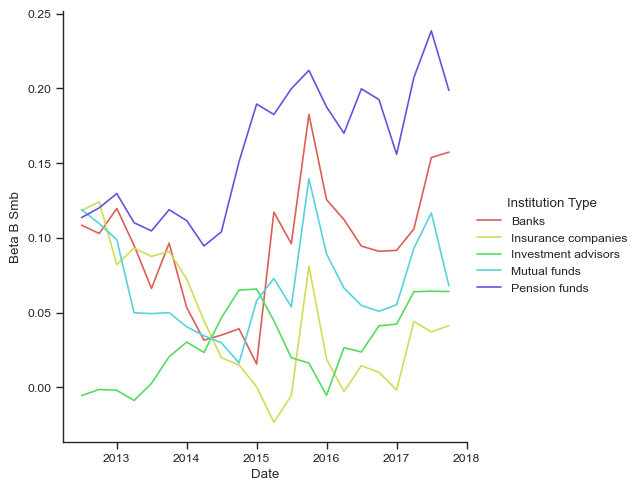

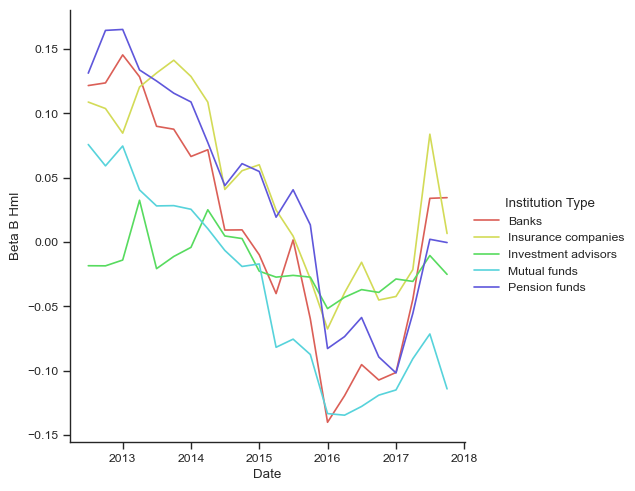

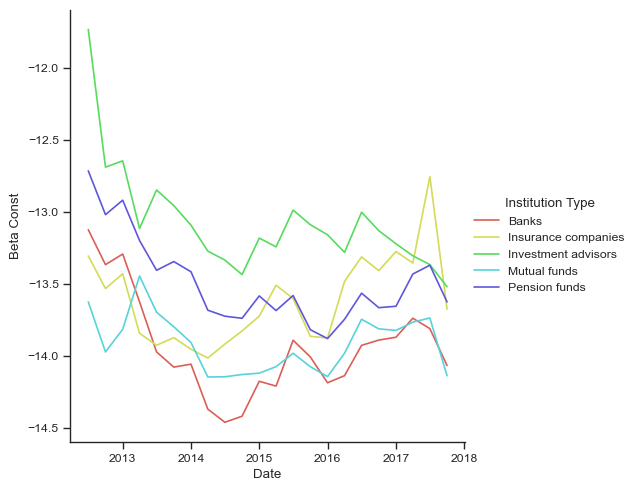

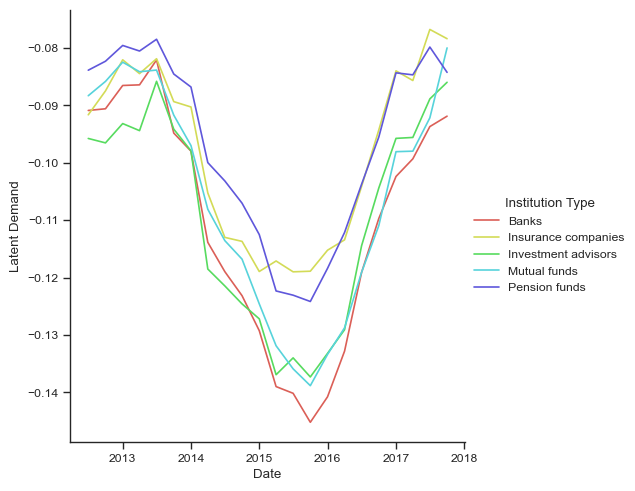

In [48]:
print('\n---------------Parameters By Typecode---------------------------\n')
_ = graph_type_params(df_figures, params, figure_path)


---------------Standard Deviation of Latent Demand By Typecode---------------------------


C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wyatt\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


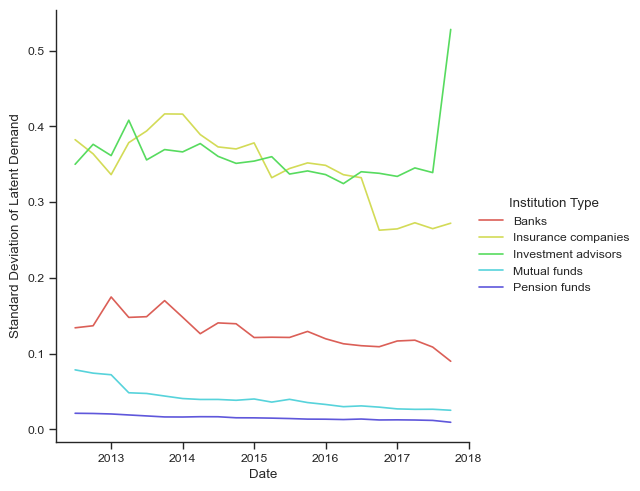

In [52]:
print('\n---------------Standard Deviation of Latent Demand By Typecode---------------------------\n')
_ = graph_std_latent_demand(df_figures, figure_path)

In [ ]:
print('\n---------------Simulating Demand Shock---------------------------\n')


In [ ]:
print('\n---------------Testing Predictability---------------------------\n')


In [ ]:
print('\n---------------Simulating Monetary Policy Shock---------------------------\n')


In [ ]:
print('\n---------------Finished---------------------------\n')